# Prácticum I

Nota: Tanto el código como los comentarios están en inglés.

The use of machine learning models in financial markets has recently gained relevance due to their ability to identify patterns in historical data and improve investment decision-making. This project aims to develop a machine learning model to predict the direction of a financial asset’s price within a given interval, analyzing the relationship between technical indicators and market behavior. To that end, public data containing two years of historical information in one-minute intervals will be used, cleaned, and transformed using financial indicators.

Likewise, various machine learning models will be evaluated to determine their accuracy in price prediction, seeking to identify the optimal time interval in which the model achieves the highest accuracy. Finally, the study will explore the integration of these models into automated trading strategies, considering their opportunities and limitations in real-world scenarios.

## Methodolgy

The methodology of the project goes as follows:

1. Download the historical stock price data, as well as several financial indicators, from the Alpha Vantage API in 1 minute intervals. The downloaded data will include:
    - Open, High, Low, Close, and Volume for 1 minute intervals.
    - Simple Moving Average for 10 periods.
    - Exponential Moving Average for 10 periods.
    - Volume-Weighted Average Price.
    - Moving Average Convergence/Divergence for 12, 26, and 9 periods for the corresponding parameters.
    - Stochastic Oscillator for 14 periods with a 3 period moving average.
    - Momentum for 1 period.
    - Bollinger Bands for 20 periods.
    - Relative Strength Index for 14 periods.
2. Feature engineering of the dataset to create a target variable indicating if the price increases or decreases in the next interval. The intervals used for this will be:
    - 1 minute
    - 3 minutes
    - 5 minutes
    - 10 minutes
    - 15 minutes
    - 30 minutes
3. Create and train a machine learning model to predict the targer variable. The machine learning models used will be:
    - Decision Tree
    - Random Forest
    - XGBoost
4. Test the machine learning model. The metrics used for testing will include:
    - F1-Score
    - Recall
    - Precision
5. Setup a backtesting algorithm to improve the accuracy of the model.

(Note: A random state of 77 will be used across the code for reproducibility.)

## 1. Import libraries

The following libraries will be used for the creation of the machine learning model.

In [ ]:
# Data processing
import numpy as np
import pandas as pd
import re

# Import datasets
import os
import requests

# Runtime
import time

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import classification_report, f1_score, make_scorer

# Hyperparameters fine-tuning
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

## 2. Import datasets

The first step is to download the historical stock price data and financial indicators from the Alpha Vantage API, saving it in csv format for future use. Several functions have been created to simplify the download process of the data.

In [3]:
def create_url(function: str, symbol: str, interval: str, year: str, month: str, apikey: str, time_period: str, series_type: str, fastkperiod: str, fastdperiod: str) -> str:
    """
    This function creates the url to fetch the data from the Alpha Vantage API.

    Args:
        function (str): The Alpha Vantage API function.
        symbol (str): The stock ticker to query.
        interval (str): Time interval for the data.
        year (str): Year to fetch data for.
        month (str): Month to fetch data for.
        apikey (str): Your Alpha Vantage API key.
        time_period (str): Time period interval to apply the function.
        series_type (str): Series type selected to fetch data.
        fastkperiod (str): Time period of the fastk moving average.
        fastdperiod (str): Time period of the fastd moving average.

    Returns:
        str: The complete url to fetch the data.
    """

    # Functions categorised by their parameters
    functions_1 = ["TIME_SERIES_INTRADAY"]                              # requires outputsize
    functions_2 = ["SMA", "EMA", "MOM", "ROC", "BBANDS", "RSI"]         # requires time_period
    functions_3 = ["SMA", "EMA", "MACD", "MOM", "ROC", "BBANDS", "RSI"] # requires series_type
    functions_4 = ["STOCHF"]                                            # requiers fastkperiod and fastdperiod

    # Create url to fetch data
    # Initial parameters for all url
    url = (
        "https://www.alphavantage.co/query?function=" + function + 
        "&symbol=" + symbol + 
        "&interval=" + interval + 
        "&month=" + year + "-" + month
    )
    
    # Parameters depending on the function
    if function in functions_1:
        url = url + "&outputsize=full"
    
    if function in functions_2:
        url = url + "&time_period=" + time_period

    if function in functions_3:
        url = url + "&series_type=" + series_type

    if function in functions_4:
        url = url + "&fastkperiod=" + fastkperiod + "&fastdperiod=" + fastdperiod

    # API keys used
    # 5EGL4AETQO7XFE3A Alan
    # AV63J01W587OXBRX Fong
    url = url + "&apikey=" + apikey

    return url

In [4]:
def fetch_data(url: str) -> pd.DataFrame:
    """
    Fetches data from the given API URL, extracts the relevant time series data, and converts it into a Pandas DataFrame.

    Args:
        url (str): The API url to fetch the data.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted time series data, indexed by the original keys.
    """

    # Request data from the API
    r = requests.get(url)
    data = r.json()

    if "Information" in data:
        print("Error:", data["Information"])
    else:
        print("API data retrieved successfully")

        # Extract the data of the JSON
        key = list(data.keys())[1]
        function_data = data.get(key, {})

        # Convert the Time Series data into a DataFrame
        df = pd.DataFrame.from_dict(function_data, orient="index")

        return df

In [5]:
def save_data(stock: pd.DataFrame, function: str, symbol: str) -> None:
    """
    This function saves the stock data for the function as a CSV

    Args:
        stock (pd.DataFrame): The combined DataFrame containing the fetched data.
        function (str): The Alpha Vantage API function.
        symbol (str): The stock ticker to query.
    """

    # Create directory to save file
    DATA_PATH = symbol
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)

    # Save the combined DataFrame to a CSV file
    stock.to_csv(symbol + "/" + symbol + " " + function + ".csv", index=True)

In [6]:
def alpha_download(function: str, symbol: str, interval: str, years: list, months: list, apikey: str, time_period: str, series_type: str, fastkperiod: str, fastdperiod: str) -> pd.DataFrame:
    """
    Download stock data from Alpha Vantage for specific years and months and save it as a CSV.

    This function fetches stock data from the Alpha Vantage API for the specified parameters.
    The data is combined into a Pandas DataFrame and saved to a CSV file.

    Note: The function is maxed out to 25 calls for each Key.

    Args:
        function (str): The Alpha Vantage API function.
        symbol (str): The stock ticker to query.
        interval (str): Time interval for the data.
        years (list of str): List of years to fetch data for.
        months (list of str): List of months to fetch data for.
        apikey (str): Your Alpha Vantage API key.
        time_period (str): Time period interval to apply the function.
        series_type (str): Series type selected to fetch data.
        fastkperiod (str): Time period of the fastk moving average.
        fastdperiod (str): Time period of the fastd moving average.
        
    Returns:
        pd.DataFrame: The combined DataFrame containing the fetched data.
    """
    
    # Initialize an empty DataFrame to store the combined data
    stock = pd.DataFrame()

    # Fetch data
    for year in years:
        for month in months:
            
            # Create url
            url = create_url(function, symbol, interval, year, month, apikey, time_period, series_type, fastkperiod, fastdperiod)
            
            # Request data from the API and asign to DataFrame
            df = fetch_data(url)

            # Append to the main DataFrame
            stock = pd.concat([df, stock])
    
    # Reorder the index and adjust format
    stock.reset_index(drop=False, inplace=True)
    stock.sort_index(ascending=False, inplace=True)
    stock["index"] = pd.to_datetime(stock["index"]).dt.strftime('%Y-%m-%d %H:%M:%S')
    stock.set_index("index", inplace=True)

    save_data(stock, function, symbol)

    return stock

In [7]:
def read_data(function: str, symbol: str, interval: str, years: list, months: list, apikey: str, time_period: str = "", series_type: str = "", fastkperiod: str = "", fastdperiod: str = "") -> pd.DataFrame:
    """
    Read stock data from Alpha Vantage for specific functions, years and months.

    Args:
        function (str): The Alpha Vantage API function.
        symbol (str): The stock ticker to query.
        interval (str): Time interval for the data.
        years (list of str): List of years to fetch data for.
        months (list of str): List of months to fetch data for.
        apikey (str): Your Alpha Vantage API key.
        time_period (str, optional): Time period interval to apply the function. Defalt value is empty string.
        series_type (str, optional): Series type selected to fetch data. Defalt value is empty string.
        fastkperiod (str, optional): Time period of the fastk moving average. Defalt value is empty string.
        fastdperiod (str, optional): Time period of the fastd moving average. Defalt value is empty string.

    Returns:
        pd.DataFrame: The DataFrame containing the data.
    """
    
    # Data path for the data file
    DATA_PATH = symbol + "/" + symbol + " " + function + ".csv"

    # Confirms if the file exists
    if os.path.exists(DATA_PATH):
        # Reads the csv file into a DataFrame
        print("Function file exists")
        stock = pd.read_csv(DATA_PATH, index_col=0)

    else:
        # Downloads the data from the API
        print("Creating function file")
        stock = alpha_download(function, symbol, interval, years, months, apikey, time_period, series_type, fastkperiod, fastdperiod)
        print("Function file created")
        
    return stock

In [8]:
def read_merged_data(symbol: str, interval: str, years: list, months: list, apikey: str, functions: list) -> pd.DataFrame:
    """
    Read stock data from Alpha Vantage for multiple functions, years and months.
    
    Args:
        symbol (str): The stock ticker symbol.
        interval (str): The time interval for the stock data.
        years (list): A list of years for which data is retrieved.
        months (list): A list of months for which data is retrieved.
        apikey (str): The API key for accessing the data.
        functions (list): A list of tuples where each tuple contains:
            - function (str): The Alpha Vantage API function.
            - Optional parameters for the function:
                - time_period (str): Time period interval to apply the function.
                - series_type (str): Series type selected to fetch data.
                - fastkperiod (str): Time period of the fastk moving average.
                - fastdperiod (str): Time period of the fastd moving average.
    
    Returns:
        pd.DataFrame: A merged DataFrame containing the requested stock data.
    """

    # Data path for the data file
    path_symbol = symbol.replace("/", "_")

    DATA_PATH = path_symbol + "/" + path_symbol + "_" + interval + ".csv"

    # Confirms if the file exists
    if os.path.exists(DATA_PATH):
        # Reads the csv file into a DataFrame
        print("Complete file exists")
        stock = pd.read_csv(DATA_PATH, index_col=0)
    
    else:
        # Merges from previous datasets
        print("Creating merged file")

        # Initialize an empty DataFrame to store the combined data
        stock = None
        
        # Read the data for each function
        for function_name, *optional_params in functions:
            df = read_data(function_name, symbol, interval, years, months, apikey, *optional_params)

            # Merge the datasets
            if stock is None:
                stock = df
            else:
                stock = pd.merge(stock, df, left_index=True, right_index=True)
        
        # Save the combined DataFrame to a CSV file
        stock.to_csv(symbol + "/" + symbol + ".csv", index=True)
        print("Merged file created")
    
    # Ensure the DataFrame type is numeric
    stock = stock.apply(pd.to_numeric)

    # Confirms that the complete file is imported
    print("Complete file imported")

    return stock

The following technical indicators will be included, with the follwing parameters for each one:
- Open, High, Low, Close, and Volume (only for stocks) for 1 minute intervals.
- Simple Moving Average for 10 periods.
- Exponential Moving Average for 10 periods.
- Volume-Weighted Average Price.
- Moving Average Convergence/Divergence for 12, 26, and 9 periods for the corresponding parameters.
- Stochastic Oscillator for 14 periods with a 3 period moving average.
- Momentum for 1 period.
- Rate of Change for 1 period.
- Bollinger Bands for 20 periods.
- Relative Strength Index for 14 periods.

In [9]:
# Create stock dataset
symbol = "EUR/USD"
interval = "1min"
years = ["2022", "2023"]    #["2022", "2023"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]   #["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
apikey = "" # Change when downloading data

functions_list = [
    ("TIME_SERIES_INTRADAY", "", ""),
    ("SMA", "10", "close", "", ""),
    ("EMA", "10", "close", "", ""),
    ("STOCHF", "", "", "14", "3"),
    ("MOM", "1", "close", "", ""),
    ("BBANDS", "20", "close", "", ""),
    ("RSI", "14", "close", "", "")
]

stock = read_merged_data(symbol, interval, years, months, apikey, functions_list)

Complete file exists
Complete file imported


Now, a dataframe containing the merged data from each function for the selected years for the stock has been created.

Visualisation of the dataset characteristics and general behaviour.

In [10]:
# Visualize the general view of the stock dataframe
stock

,open,high,low,close,sma,ema,vwap,macd,macd_signal,macd_hist,fast_k,fast_d,mom,roc,upper_band,middle_band,lower_band,rsi
datetime,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,1.13255,1.13270,1.1325,1.1327,1.13286,1.13284,1.13263,-0.00004,0.00005,-0.00009,19.99285,12.25175,0.00015,0.01324,1.13360,1.13306,1.13253,43.09303
2022-01-01 00:01:00,1.13275,1.13275,1.1325,1.1325,1.13279,1.13278,1.13258,-0.00007,0.00002,-0.00009,0.00000,8.32936,-0.00020,-0.01765,1.13363,1.13304,1.13245,38.15357
2022-01-01 00:02:00,1.13250,1.13270,1.1325,1.1326,1.13274,1.13275,1.13260,-0.00008,0.00000,-0.00008,9.99046,9.99444,0.00010,0.00882,1.13364,1.13302,1.13240,41.74682
2022-01-01 00:03:00,1.13250,1.13270,1.1325,1.1326,1.13272,1.13272,1.13260,-0.00009,-0.00002,-0.00007,9.99046,6.66031,0.00000,0.00000,1.13361,1.13298,1.13236,41.74682
2022-01-01 00:04:00,1.13260,1.13270,1.1325,1.1327,1.13270,1.13272,1.13263,-0.00009,-0.00003,-0.00006,23.52034,14.50042,0.00010,0.00883,1.13358,1.13295,1.13233,45.42834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 06:55:00,1.10400,1.10400,1.1038,1.1039,1.10416,1.10412,1.10390,-0.00007,-0.00006,-0.00001,16.65011,13.88337,-0.00010,-0.00906,1.10445,1.10420,1.10394,40.40055
2023-12-30 06:56:00,1.10400,1.10410,1.1040,1.1041,1.10414,1.10412,1.10407,-0.00007,-0.00006,-0.00001,49.99007,22.21339,0.00020,0.01812,1.10445,1.10420,1.10394,46.86666
2023-12-30 06:57:00,1.10400,1.10400,1.1040,1.1040,1.10413,1.10410,1.10400,-0.00008,-0.00006,-0.00001,33.32009,33.32009,-0.00010,-0.00906,1.10445,1.10418,1.10391,44.27986


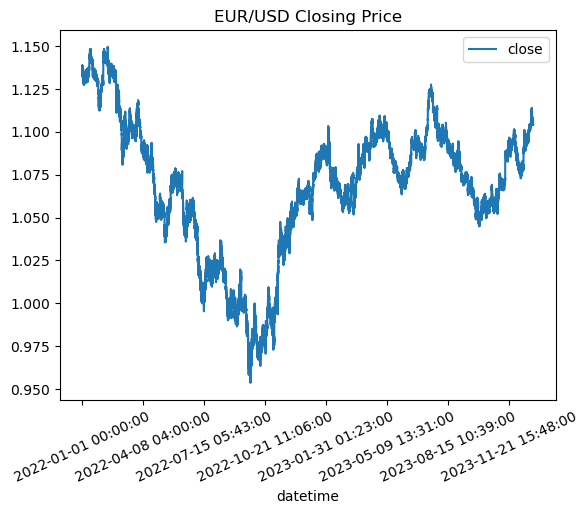

In [11]:
# Visualize stock close prices
stock.plot.line(y = "close", title = symbol + " Closing Price").tick_params(axis = "x", labelrotation = 25)

## 3. Data Manipulation

Different target variables will be created for different time intervals. The objective is to evaluate the performance in the prediction across different intervals. The intervals used will be:
- 1 minute
- 3 minutes
- 5 minutes
- 10 minutes
- 15 minutes
- 30 minutes

In [12]:
def create_targets(stock: pd.DataFrame, intervals: list, predictors: list) -> pd.DataFrame:
    """
    Creates a DataFrame including multiple target columns indicating whether the close price is higher after a given interval.
    Then appends the specified predictors from the stock DataFrame.

    Args:
        stock (pd.DataFrame): DataFrame containing the stock information.
        intervals (list): A list of integers representing the intervals after which to check if the close price increased.
        predictors (list): A list of column names from `stock` to be joined as additional features in the output DataFrame.

    Returns:
        pd.DataFrame: DataFrame containing the newly created target columns and the specified predictors.
    """

    # Base stock DataFrame with 'Actual_close'
    data = stock[["close"]].rename(columns={"close": "Actual_close"})

    # Create target columns for each interval
    for minutes in intervals:
        col_name = f"Target_{minutes}"

        future_close = stock["close"].shift(-minutes)
        data[col_name] = future_close > (stock["close"])
        data[col_name] = data[col_name].astype(int)

    # Join the predictors from the original stock DataFrame
    data = data.join(stock[predictors])

    # Drop the initial rows where rolling calculations yield NaN
    data = data.iloc[max(intervals):]

    # Drop 'Actual_close' since it's no longer needed
    data.drop("Actual_close", axis=1, inplace=True)

    # Reset the index and drop any remaining NaNs
    data.reset_index(drop=True, inplace=True)
    data.dropna(axis=0, inplace=True)

    return data

In [13]:
# Specify the intervals for the target columns
intervals = [1, 3, 5, 10, 15, 30]
Targets = [f"Target_{minutes}" for minutes in intervals]

# Specify the columns used as predictors
predictors = stock.columns.tolist()

data = create_targets(stock, intervals, predictors)

In [14]:
# Visualize the first instances of the new data dataframe
pd.set_option("display.max_columns", None)
data.head(15)

,Target_1,Target_3,Target_5,Target_10,Target_15,Target_30,open,high,low,close,sma,ema,vwap,macd,macd_signal,macd_hist,fast_k,fast_d,mom,roc,upper_band,middle_band,lower_band,rsi
0,0,1,1,1,1,1,1.13285,1.13285,1.13265,1.1327,1.13253,1.13262,1.13273,0.00001,-0.00007,0.00008,71.42371,90.47457,-0.0003,-0.02648,1.13315,1.13250,1.13185,53.33065
1,1,1,1,1,1,1,1.13260,1.13260,1.13240,1.1324,1.13255,1.13258,1.13247,-0.00000,-0.00006,0.00005,42.85876,71.42749,-0.0003,-0.02648,1.13306,1.13247,1.13187,45.69384
2,1,0,0,1,1,1,1.13245,1.13290,1.13245,1.1329,1.13261,1.13264,1.13275,0.00003,-0.00004,0.00006,90.47457,68.25235,0.0005,0.04415,1.13306,1.13247,1.13187,56.79914
3,0,0,0,1,1,1,1.13295,1.13315,1.13290,1.1331,1.13269,1.13272,1.13305,0.00006,-0.00002,0.00008,95.65668,76.33000,0.0002,0.01766,1.13310,1.13248,1.13185,60.29737
4,0,0,1,1,1,1,1.13305,1.13305,1.13285,1.1329,1.13275,1.13275,1.13293,0.00007,-0.00000,0.00007,78.26267,88.13131,-0.0002,-0.01765,1.13315,1.13249,1.13184,55.46091
5,0,1,1,1,1,1,1.13300,1.13300,1.13285,1.1329,1.13280,1.13278,1.13292,0.00008,0.00002,0.00007,78.26267,84.06068,0.0000,0.00000,1.13319,1.13252,1.13184,55.46091
6,1,1,1,1,1,1,1.13290,1.13290,1.13280,1.1328,1.13283,1.13278,1.13283,0.00008,0.00003,0.00005,63.15723,73.22753,-0.0001,-0.00883,1.13322,1.13254,1.13185,52.99594
7,1,1,1,1,1,1,1.13285,1.13290,1.13285,1.1329,1.13286,1.13280,1.13288,0.00009,0.00004,0.00005,73.68553,71.70181,0.0001,0.00883,1.13326,1.13257,1.13187,55.14297
8,1,1,1,1,1,1,1.13290,1.13300,1.13290,1.1330,1.13286,1.13284,1.13297,0.00010,0.00005,0.00005,82.35624,73.06634,0.0001,0.00883,1.13330,1.13261,1.13192,57.24610
9,1,1,1,1,1,1,1.13300,1.13320,1.13290,1.1332,1.13288,1.13291,1.13310,0.00012,0.00007,0.00006,100.00000,85.34726,0.0002,0.01766,1.13335,1.13267,1.13199,61.16752


In [15]:
# Visualize the last instances of the new data dataframe
data.tail(15)

,Target_1,Target_3,Target_5,Target_10,Target_15,Target_30,open,high,low,close,sma,ema,vwap,macd,macd_signal,macd_hist,fast_k,fast_d,mom,roc,upper_band,middle_band,lower_band,rsi
739156,0,0,0,0,0,0,1.10430,1.10440,1.1042,1.1044,1.10424,1.10424,1.10433,-0.00006,-0.00012,0.00006,100.00000,80.00000,0.0002,0.01812,1.10440,1.10415,1.10390,53.91597
739157,0,1,0,0,0,0,1.10440,1.10440,1.1042,1.1043,1.10425,1.10425,1.10430,-0.00005,-0.00010,0.00005,80.00000,80.00000,-0.0001,-0.00906,1.10441,1.10415,1.10389,50.09284
739158,0,1,1,0,0,0,1.10420,1.10420,1.1040,1.1041,1.10423,1.10422,1.10410,-0.00006,-0.00009,0.00004,40.00000,73.33333,-0.0002,-0.01811,1.10441,1.10415,1.10389,43.45594
739159,1,0,0,0,0,0,1.10415,1.10415,1.1040,1.1041,1.10422,1.10420,1.10408,-0.00006,-0.00009,0.00002,40.00000,53.33333,0.0000,0.00000,1.10441,1.10416,1.10390,43.45594
739160,0,0,0,0,0,0,1.10430,1.10440,1.1042,1.1044,1.10425,1.10424,1.10433,-0.00004,-0.00008,0.00004,100.00000,60.00000,0.0003,0.02718,1.10444,1.10417,1.10390,54.04749
739161,0,0,0,0,0,0,1.10440,1.10440,1.1043,1.1043,1.10425,1.10425,1.10433,-0.00003,-0.00007,0.00004,75.00000,71.66667,-0.0001,-0.00906,1.10446,1.10418,1.10390,50.64224
739162,1,0,0,0,0,0,1.10420,1.10430,1.1041,1.1041,1.10424,1.10422,1.10417,-0.00004,-0.00006,0.00002,25.00000,66.66667,-0.0002,-0.01811,1.10446,1.10418,1.10390,44.59111
739163,0,0,0,0,0,0,1.10420,1.10430,1.1042,1.1043,1.10425,1.10423,1.10427,-0.00003,-0.00006,0.00003,75.00000,58.33333,0.0002,0.01812,1.10447,1.10419,1.10390,50.90820
739164,0,0,0,0,0,0,1.10420,1.10420,1.1040,1.1041,1.10423,1.10421,1.10410,-0.00004,-0.00005,0.00001,25.00000,41.66667,-0.0002,-0.01811,1.10445,1.10420,1.10394,45.34127
739165,0,0,1,0,0,0,1.10410,1.10410,1.1040,1.1040,1.10421,1.10417,1.10403,-0.00005,-0.00005,-0.00000,0.00000,33.33333,-0.0001,-0.00906,1.10444,1.10420,1.10397,42.81995


## 4. Machine Learning

Several machine learning models will be trained and tested for precision across different time intervals. The following performance metrics will be printed for each factor combination of train size, model, time interval, and value:
- Precision
- Recall
- F1-Score

The machine learning models used will be:
- Decision Tree
- Random Forest
- XGBoost

### 4.1 Initial testing

An initial testing of the models with default parameters will be done to analyse different training sizes and intervals used. A test size of 2000 will be used to test the results and obtain the performance metrics.

In [16]:
def create_report(value: int, value_str: str, train_size: int, model_name: str, target: str, report: dict) -> list:
    """
    Generates a single row of classification metrics for a given class label.

    This function extracts precision, recall, F1-score, and support from the classification report dictionary.

    Args:
        value (int): The numeric class label.
        value_str (str): The string version of the class label used as a key in the classification report dictionary.
        train_size (int): The size of the training set used to for the model.
        model_name (str): A string identifier for the model used.
        target (str): The target variable name.
        report (dict): A dictionary produced by `classification_report` containing metrics for each class label.

    Returns:
        list: A list of metrics for each factor combination.
    """

    # Create each row according to each combination of factors
    report_row = [
        train_size,
        model_name,
        target,
        value,
        report[value_str]["precision"],
        report[value_str]["recall"],
        report[value_str]["f1-score"],
        report[value_str]["support"]
    ]

    return report_row

In [17]:
def evaluate_model(train: pd.DataFrame, test: pd.DataFrame, model: object, model_name: str, train_size: int, Targets: list, predictors: list) -> list:
    """
    Fits a given model on a training set, evaluates it on a test set for multiple targets, and returns a list of classification metrics for each target and class label.

    Args:
        train (pd.DataFrame): The training portion of the dataset, containing predictor and target columns.
        test (pd.DataFrame): The testing portion of the dataset to evaluate the model's performance.
        model (object): An instantiated ML model.
        model_name (str): Identifier for the model.
        train_size (int): Number of rows used for training.
        Targets (list): A list of target column names.
        predictors (list): A list of column names in `train` and `test` used as features.

    Returns:
        list: A list of rows, where each row contains:
    """

    # List with the results for the metrics of the model
    df_results = []

    # Fit the model
    model.fit(train[predictors], train[Targets])

    # Predict
    y_pred = model.predict(test[predictors])
    y_pred = pd.DataFrame(y_pred, columns=Targets)
    
    # Generate the classification report and metrics for each target variable.
    for target in Targets:
        report = classification_report(
            y_true = test[target],
            y_pred = y_pred[target],
            zero_division = 0,
            output_dict = True
        )
        
        # Value 0
        df_results.append(create_report(0, "0", train_size, model_name, target, report))

        # Value 1
        df_results.append(create_report(1, "1", train_size, model_name, target, report))
    
    return df_results

In [18]:
def test_models(data: pd.DataFrame, predictors: list, Targets: list, methods: dict, train_sizes: list, test_size: int) -> pd.DataFrame:
    """
    Evaluates multiple models on different train sizes, returning a combined DataFrame of classification metrics for each train size, model, and target.

    Args:
        data (pd.DataFrame): The full dataset including both predictor columns and the target columns.
        predictors (list): Column names in `data` to be used as features during model training and prediction.
        Targets (list): Column names in `data` to be used as target variables.
        methods (dict): A dictionary containign the models to evaluate.
        train_sizes (list): A list of integers specifying the number of rows to use for training 
        test_size (int): Number of rows from the end of the dataset to reserve for testing in each iteration.

    Returns:
        pd.DataFrame: A concatenated multi-level indexed DataFrame containing classification metrics.
    """
    
    # DataFrame with the results from all training sizes
    df_results_all = []

    # Run the model for different train sizes
    for train_size in train_sizes:

        # Status update
        print("Currently training a train size of:", str(train_size))

        # Create train and test subsets
        train = data.iloc[-(train_size + test_size): -test_size]  # the last train_size instances before testing
        test = data.iloc[-test_size:]     # last test_size rows instances for testing

        # List for this train size metric results
        df_results_loop = []
        
        # Evaluate the metrics for every model for this train size
        for model_name, model in methods.items():
            # Status update
            print("Currently training the model:", str(model_name))
            t0 = time.time()

            df_results_loop.extend(evaluate_model(train, test, model, model_name, train_size, Targets, predictors))

            elapsed = time.time() - t0
            print(f"Time = {elapsed:.2f}s")

        # Convert results to a DataFrame
        df_results_loop = pd.DataFrame(df_results_loop, columns = ["Train_Size", "Model", "Variable", "Value", "Precision", "Recall", "F1-Score", "Support"])
        
        # Set multi-level index
        df_results_loop.set_index(
            ["Train_Size", "Model", "Variable", "Value"],
            inplace=True
        )

        df_results_all.append(df_results_loop)

    # Concatenate all results
    return pd.concat(df_results_all)

In [19]:
# Dictionary of models to test
methods = {
    'Decision Tree Classifier': DecisionTreeClassifier(random_state = 77),
    'Random Forest Classifier': RandomForestClassifier(random_state = 77, n_jobs = -1),
    'XGBoost': xgb.XGBClassifier(random_state = 77, n_jobs = -1),
}

# Train and test sizes to test
train_sizes = [100000, 50000, 25000, 10000, 5000]
test_size = 2000

metric_results = test_models(data, predictors, Targets, methods, train_sizes, test_size)

Currently training a train size of: 100000
Currently training the model: Decision Tree Classifier
Time = 4.38s
Currently training the model: Random Forest Classifier
Time = 14.61s
Currently training the model: XGBoost
Time = 2.91s
Currently training a train size of: 50000
Currently training the model: Decision Tree Classifier
Time = 1.93s
Currently training the model: Random Forest Classifier
Time = 6.58s
Currently training the model: XGBoost
Time = 1.69s
Currently training a train size of: 25000
Currently training the model: Decision Tree Classifier
Time = 0.81s
Currently training the model: Random Forest Classifier
Time = 2.88s
Currently training the model: XGBoost
Time = 1.32s
Currently training a train size of: 10000
Currently training the model: Decision Tree Classifier
Time = 0.31s
Currently training the model: Random Forest Classifier
Time = 1.18s
Currently training the model: XGBoost
Time = 1.06s
Currently training a train size of: 5000
Currently training the model: Decision Tr

In [20]:
# Visualize the some instances of the metrics dataframe
metric_results

Precision    Recall  \
Train_Size Model                    Variable  Value                        
100000     Decision Tree Classifier Target_1  0       0.629848  0.609299   
                                              1       0.411548  0.432817   
                                    Target_3  0       0.602927  0.519328   
                                              1       0.413333  0.497531   
                                    Target_5  0       0.587049  0.474678   
...                                                        ...       ...   
5000       XGBoost                  Target_10 1       0.468966  0.699429   
                                    Target_15 0       0.576238  0.271709   
                                              1       0.478261  0.769645   
                                    Target_30 0       0.630824  0.166825   
                                              1       0.489250  0.891005   

                                                     F1-Score  Support  
Train_Size Model                    Variable  Value                     
100000     Decision Tree Classifier Target_1  0      0.619403   1226.0  
                                              1      0.421914    774.0  
                                    Target_3  0      0.558014   1190.0  
                                              1      0.451541    810.0  
                                    Target_5  0      0.524917   1165.0  
...                                                       ...      ...  
5000       XGBoost                  Target_10 1      0.561468    875.0  
                                    Target_15 0      0.369289   1071.0  
                                              1      0.589934    929.0  
                                    Target_30 0      0.263868   1055.0  
                                              1      0.631658    945.0  

[180 rows x 4 columns]

In [21]:
# Visualize the best performing models from the DataFrame
filtered_metrics = metric_results[
    (metric_results["Precision"] >= 0.5) &
    (metric_results["Recall"] >= 0.5) &
    (metric_results["F1-Score"] >= 0.5)
]

filtered_metrics.sort_values(by="F1-Score", ascending=False).head(20)

Precision    Recall  \
Train_Size Model                    Variable Value                        
50000      Random Forest Classifier Target_1 0       0.634547  0.725122   
100000     Random Forest Classifier Target_1 0       0.625348  0.732463   
           XGBoost                  Target_1 0       0.627874  0.712887   
5000       Random Forest Classifier Target_1 0       0.634559  0.703915   
10000      Random Forest Classifier Target_1 0       0.627941  0.696574   
25000      Random Forest Classifier Target_1 0       0.634572  0.682708   
           XGBoost                  Target_1 0       0.642072  0.667210   
50000      XGBoost                  Target_1 0       0.641066  0.667210   
10000      XGBoost                  Target_1 0       0.642324  0.631321   
5000       XGBoost                  Target_1 0       0.636594  0.615824   
100000     Decision Tree Classifier Target_1 0       0.629848  0.609299   
50000      Decision Tree Classifier Target_1 0       0.621598  0.577488   
25000      Decision Tree Classifier Target_1 0       0.613460  0.579935   
10000      Decision Tree Classifier Target_1 0       0.625117  0.544046   
5000       Random Forest Classifier Target_3 0       0.612426  0.521849   
50000      Random Forest Classifier Target_3 0       0.607004  0.524370   
100000     Random Forest Classifier Target_3 0       0.600191  0.528571   
           XGBoost                  Target_3 0       0.626819  0.506723   
           Decision Tree Classifier Target_3 0       0.602927  0.519328   
10000      Random Forest Classifier Target_3 0       0.611504  0.509244   

                                                    F1-Score  Support  
Train_Size Model                    Variable Value                     
50000      Random Forest Classifier Target_1 0      0.676818   1226.0  
100000     Random Forest Classifier Target_1 0      0.674681   1226.0  
           XGBoost                  Target_1 0      0.667685   1226.0  
5000       Random Forest Classifier Target_1 0      0.667440   1226.0  
10000      Random Forest Classifier Target_1 0      0.660480   1226.0  
25000      Random Forest Classifier Target_1 0      0.657760   1226.0  
           XGBoost                  Target_1 0      0.654400   1226.0  
50000      XGBoost                  Target_1 0      0.653877   1226.0  
10000      XGBoost                  Target_1 0      0.636775   1226.0  
5000       XGBoost                  Target_1 0      0.626036   1226.0  
100000     Decision Tree Classifier Target_1 0      0.619403   1226.0  
50000      Decision Tree Classifier Target_1 0      0.598732   1226.0  
25000      Decision Tree Classifier Target_1 0      0.596226   1226.0  
10000      Decision Tree Classifier Target_1 0      0.581771   1226.0  
5000       Random Forest Classifier Target_3 0      0.563521   1190.0  
50000      Random Forest Classifier Target_3 0      0.562669   1190.0  
100000     Random Forest Classifier Target_3 0      0.562109   1190.0  
           XGBoost                  Target_3 0      0.560409   1190.0  
           Decision Tree Classifier Target_3 0      0.558014   1190.0  
10000      Random Forest Classifier Target_3 0      0.555708   1190.0

From the metrics observed a model can be selected according to the best performing one in this phase.

### 4.2 Model selection

The model selected for further fine tuning will be the model shown as the best in the metrics DataFrame.

In [22]:
# Best model
filtered_metrics.sort_values(by="F1-Score", ascending=False).head(1)

,,,,Precision,Recall,F1-Score,Support
Train_Size,Model,Variable,Value,,,,
50000,Random Forest Classifier,Target_1,0,0.634547,0.725122,0.676818,1226.0


In [23]:
# Obtain the training characteristics for the best initial model
initial_parameters = filtered_metrics["F1-Score"].idxmax()

train_size, model_name, target, label = initial_parameters
model = methods[initial_parameters[1]]

In [24]:
# Declare the new train and test DataFrames
train = data.iloc[-(train_size + test_size): -test_size]
test = data.iloc[-test_size:]

In [25]:
# Analyse performance before fine tuning
model.fit(train[predictors], train[target])
y_pred = model.predict(test[predictors])

print(classification_report(y_pred = y_pred, y_true = test[target]))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1226
           1       0.43      0.36      0.39       774

    accuracy                           0.57      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.56      0.57      0.56      2000



### 4.3 Fine Tuning Hyperparameters

The hyperparameters for the model selected will be fine tuned using Bayesian Optimization. The objective will be to optimize for the label that had the best performance in the model.

To avoid creating an overly biased model, the average F1-score across both labels will be the score to maximize.

In [26]:
# Modified scorer for f1-score
modified_f1_scorer = make_scorer(
    f1_score,
    average = "macro",
    zero_division = 0
)

In [27]:
def create_model(model_name: str, params: dict) -> object:
    """
    Creates and returns a model instance with valid parameters.

    Args:
        model_name (str): The model type.
        params (dict): Dictionary of hyperparameters.

    Returns:
        object: A machine learning model instance.
    """

    # Selects the corresponding model
    if model_name == "XGBoost":
        model = xgb.XGBClassifier(**params, use_label_encoder = False)
    
    elif model_name == "Random Forest Classifier":
        model = RandomForestClassifier(**params)
    
    elif model_name == "Decision Tree Classifier":
        model = DecisionTreeClassifier(**params)
    
    return model

In [28]:
def objective(trial: optuna.Trial, model_name: str, train_size: int, test_size: int, data: pd.DataFrame, predictors: list, target: str, modified_scorer: object) -> float:
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.Trial): An Optuna trial object used to sample hyperparameters.
        model_name (str): The model type.
        train_size (int): Maximum number of rows for training in TimeSeriesSplit.
        test_size (int): Number of rows for testing in TimeSeriesSplit.
        data (pd.DataFrame): The full dataset containing both features and the target variable.
        predictors (list): Names of the columns in `data` used as input features.
        target (str): The name of the target column in `data` for the supervised learning task.
        modified_scorer (object): A scikit-learn compatible scoring function or scorer object used for evaluating model performance in cross-validation.

    Returns:
        float: The mean cross-validation score.
    """

    # Select the corresponding model
    if model_name == "XGBoost":

        # XGBoost-specific search space
        param_grid = {
            "max_depth": trial.suggest_int("max_depth", 3, 15),                             # Maximum depth of each tree
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),                    # Number of trees or boosting rounds
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log = True),    # Step size for boosting updates
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),                        # Fraction of data per boosting iteration
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),          # Fraction of features per tree
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 10.0, log = True),            # L1 regularization
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 5.0, log = True),           # L2 regularization
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),               # Minimum sum of instance weight for further split
            "gamma": trial.suggest_float("gamma", 0, 5),                                    # Minimum loss reduction for further split
            
            # Fixed parameters
            "objective": "binary:logistic",     # XGBoost binary classification
            "n_jobs": -1,                       # Use all available cores
            "random_state": 77                  # Ensures reproducibility
        }
        
    elif model_name == "Random Forest Classifier":

        # RandomForestClassifier-specific search space
        param_grid = {
            "max_depth": trial.suggest_int("max_depth", 3, 15),                                 # Maximum depth of each tree
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),                        # Number of trees or boosting rounds
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),                 # Minimum samples per split
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),                   # Minimum samples per leaf
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),  # Number of features to consider when looking for the best split
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),           # Measure used to split nodes

            # Fixed parameters
            "n_jobs": -1,           # Use all available cores
            "random_state": 77      # Ensures reproducibility
        }
        
    elif model_name == "Decision Tree Classifier":

        # DecisionTreeClassifier-specific search space
        param_grid = {
            "max_depth": trial.suggest_int("max_depth", 3, 15),                         # Maximum depth of each tree
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),         # Minimum samples per split
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),           # Minimum samples per leaf
            "splitter": trial.suggest_categorical("splitter", ["best", "random"]),      # Defines the splitting strategy
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),   # Measure used to split nodes
            
            # Fixed parameters
            "random_state": 77      # Ensures reproducibility
        }

    # Create the model instance with the corresponding parameters
    model = create_model(model_name, param_grid)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits = 5, max_train_size = train_size, test_size = test_size)

    # Create scoring metric
    score = cross_val_score(model, data[predictors], data[target], cv = tscv, scoring = modified_scorer).mean()
    
    return score

In [29]:
# Create the study for the Bayesian Optimization, maximizing f1-score
study = optuna.create_study(
    direction = "maximize",
    sampler = optuna.samplers.TPESampler(n_startup_trials = 15),
    pruner = optuna.pruners.MedianPruner(n_warmup_steps = 15),
    study_name = "model_optimization"
)

[I 2025-04-25 22:37:54,415] A new study created in memory with name: model_optimization


In [30]:
# Run the Bayesian Optimization
study.optimize(lambda trial: objective(trial, model_name, train_size, test_size, data, predictors, target, modified_f1_scorer), n_trials = 100, n_jobs = -1)

#Best parameters
print("Best Params:", study.best_trial.params)
print("Best F1-Score:", study.best_trial.value)

[I 2025-04-25 22:41:06,844] Trial 0 finished with value: 0.403176246643637 and parameters: {'max_depth': 3, 'n_estimators': 92, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.403176246643637.
[I 2025-04-25 22:43:01,072] Trial 9 finished with value: 0.43247545979743596 and parameters: {'max_depth': 4, 'n_estimators': 338, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 9 with value: 0.43247545979743596.
[I 2025-04-25 22:43:51,261] Trial 5 finished with value: 0.47613680736796715 and parameters: {'max_depth': 10, 'n_estimators': 223, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 5 with value: 0.47613680736796715.
[I 2025-04-25 22:43:52,601] Trial 2 finished with value: 0.49598726975167795 and parameters: {'max_depth': 12, 'n_estimators': 85, 'min_samples_split': 3, 'min_samples_leaf': 1

Best Params: {'max_depth': 15, 'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}
Best F1-Score: 0.5087600910638498


In [31]:
# Create the model with the best parameters
model.set_params(**study.best_params)
model.fit(train[predictors], train[target])
y_pred = model.predict(test[predictors])

# Analyse performance after fine tuning
print(classification_report(y_pred = y_pred, y_true = test[target]))
unique, counts = np.unique(y_pred, return_counts = True)
print(dict(zip(unique, counts)))

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      1226
           1       0.44      0.25      0.32       774

    accuracy                           0.58      2000
   macro avg       0.53      0.52      0.51      2000
weighted avg       0.55      0.58      0.55      2000

{0: 1550, 1: 450}


The optimization of the hyperparameters shows a good performance of the model.

### 4.4 Backtesting

After obtaining the best model from the Bayesian Optimization, backtesting will be done across the dataset to ensure performance stays consistent across different conditions.

A backtesting algorithm will be constructed by training over a set number of instances and testing the next determined number of rows and rolling over. Therefore, training and testing over a rolling window over the whole dataset will be done.

In [32]:
def backtesting(data: pd.DataFrame, model: object, predictors: list, target: str, train_size: int, test_size: int) -> pd.DataFrame:
    """
    Perform a rolling window backtesting procedure on a time series dataset.

    Args:
        data (pd.DataFrame): The full dataset containing both features and the target variable.
        model (object): A scikit-learn compatible estimator that implements the `fit` and `predict` methods.
        predictors (list): Names of the columns in `data` that serve as input features for the model.
        target (str): The name of the column in `data` representing the target variable to predict.
        train_size (int): Number of rows to use as the rolling training set in each iteration.
        test_size (int): Number of rows to use as the test set in each iteration.

    Returns:
        pd.DataFrame: A concatenated DataFrame containing the actual and predicted values for each test window.
    """

    # DataFrame for the final predictions
    predictions = []
    n_loops = 0

    # The maximum index for starting the rolling window
    max_index = data.shape[0] - train_size - test_size

    # Calculate how many loops will be run
    total_loops = (max_index // test_size) + 1

    print(f"Starting backtesting. Will run {total_loops} loops in total.")

    # Run each rolling window of training and testing
    for i in range(0, max_index + 1, test_size):
        t0 = time.time()

        # Rolling train window
        train = data.iloc[i : i + train_size]

        # Next 'test_size' rows for testing
        test = data.iloc[i + train_size : i + train_size + test_size]

        # DataFrame to store predictions for this iteration
        preds_chunk = pd.DataFrame(index = test.index)

        # Train on the rolling window
        model.fit(train[predictors], train[target])
        y_pred = model.predict(test[predictors])

        # Store actual and predicted columns
        preds_chunk[target] = test[target]
        preds_chunk[f"Predicted_{target}"] = y_pred

        predictions.append(preds_chunk)

        n_loops += 1
        elapsed = time.time() - t0
        print(
            f"Loop {n_loops} of {total_loops}: "
            f"train = [{i}:{i + train_size}], "
            f"test = [{i + train_size}:{i + train_size + test_size}], "
            f"time = {elapsed:.2f}s"
        )

    # Concatenate the results from all test windows
    return pd.concat(predictions)

In [33]:
# Run backtesting for the best model obtained
backtest = backtesting(data, model, predictors, target, train_size, test_size)

Starting backtesting. Will run 344 loops in total.
Loop 1 of 344: train = [0:50000], test = [50000:52000], time = 1.62s
Loop 2 of 344: train = [2000:52000], test = [52000:54000], time = 1.64s
Loop 3 of 344: train = [4000:54000], test = [54000:56000], time = 1.62s
Loop 4 of 344: train = [6000:56000], test = [56000:58000], time = 1.66s
Loop 5 of 344: train = [8000:58000], test = [58000:60000], time = 1.68s
Loop 6 of 344: train = [10000:60000], test = [60000:62000], time = 1.64s
Loop 7 of 344: train = [12000:62000], test = [62000:64000], time = 1.69s
Loop 8 of 344: train = [14000:64000], test = [64000:66000], time = 1.70s
Loop 9 of 344: train = [16000:66000], test = [66000:68000], time = 1.75s
Loop 10 of 344: train = [18000:68000], test = [68000:70000], time = 1.77s
Loop 11 of 344: train = [20000:70000], test = [70000:72000], time = 1.77s
Loop 12 of 344: train = [22000:72000], test = [72000:74000], time = 1.81s
Loop 13 of 344: train = [24000:74000], test = [74000:76000], time = 1.80s
Loop

In [34]:
# Overview of the first instances of the predictions
backtest.tail(20)

,Target_1,Predicted_Target_1
737980,0,0
737981,0,0
737982,1,1
737983,0,0
737984,1,1
737985,0,0
737986,1,0
737987,0,0
737988,1,1
737989,0,0


In [42]:
time_interval = re.search(r"\d+", target).group()

# classification report of the best model with backtesting
print(f"Final Results for the {symbol} machine learning model. \n"
      f"------------------------------------------------------------------------------------------------------------- \n"
      f"Classification report of the {model_name} model after Bayesian Optimization and Backtesting. \n"
      f"Model training done with a rolling window of {train_size} instances for training and {test_size} instances for testing. \n"
      f"The label (direction) to be used is: {label}.\n"
      f"The time interval between each trade is: {time_interval} minutes. \n"
      )

report = classification_report(
    y_true = backtest[target],
    y_pred = backtest[f"Predicted_{target}"],
    zero_division = 0,
)
print(report)

Final Results for the EUR/USD machine learning model. 
------------------------------------------------------------------------------------------------------------- 
Classification report of the Random Forest Classifier model after Bayesian Optimization and Backtesting. 
Model training done with a rolling window of 50000 instances for training and 2000 instances for testing. 
The label (direction) to be used is: 0.
The time interval between each trade is: 1 minutes. 

              precision    recall  f1-score   support

           0       0.62      0.84      0.72    416078
           1       0.48      0.22      0.30    271922

    accuracy                           0.60    688000
   macro avg       0.55      0.53      0.51    688000
weighted avg       0.57      0.60      0.55    688000



It can be observed that the performance is slightly different from the default and optimized model, as this now considers backtesting through the whole dataset.

This is the final model that should be used for stock price direction prediction.